In [4]:
# Import necessary libraries
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, models
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split


ici nous on définie la classe PneumoniaDataset, configure les transformations pour les images, et initialise les DataLoaders pour les ensembles de données d'entraînement, de validation et de test.

In [6]:
class PneumoniaDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.img_files = []
        self.img_labels = []
        
        for label in ["NORMAL", "PNEUMONIA"]:
            img_dir = os.path.join(root_dir, label)
            for img_file in os.listdir(img_dir):
                self.img_files.append(os.path.join(img_dir, img_file))
                if label == "NORMAL":
                    self.img_labels.append("normal")
                else:
                    if "bacteria" in img_file:
                        self.img_labels.append("bacterie")
                    elif "virus" in img_file:
                        self.img_labels.append("virus")

    def __len__(self):
        return len(self.img_files)

    def __getitem__(self, idx):
        img_path = self.img_files[idx]
        image = Image.open(img_path).convert("RGB")
        label = self.img_labels[idx]
        if self.transform:
            image = self.transform(image)
        label_map = {'normal': 0, 'bacterie': 1, 'virus': 2}
        label = label_map[label]
        return image, label

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

dataset = PneumoniaDataset(root_dir='../data', transform=transform)

train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

In [11]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(32 * 56 * 56, 128)
        self.fc2 = nn.Linear(128, 3)
        self.relu = nn.ReLU()
        self.logsoftmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = x.view(-1, 32 * 56 * 56)
        x = self.relu(self.fc1(x))
        x = self.logsoftmax(self.fc2(x))
        return x

# Initializer le modèle
model = SimpleCNN()

# Move the model to GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [8]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

- Entrainer le modèle

In [9]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=3):
    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)
        
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()
            
            running_loss = 0.0
            running_corrects = 0
            
            for i, (inputs, labels) in enumerate(dataloaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                optimizer.zero_grad()
                
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                
                print(f"Batch {i+1}/{len(dataloaders[phase])} completed")

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)
            
            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
    
    return model

# Dataloaders for training and validation
dataloaders = {'train': train_loader, 'val': val_loader}

# Train the model
print("Starting training...")
model = train_model(model, dataloaders, criterion, optimizer, num_epochs=3)
print("Training completed.")

Starting training...
Epoch 0/2
----------
Batch 1/14 completed
Batch 2/14 completed
Batch 3/14 completed
Batch 4/14 completed
Batch 5/14 completed
Batch 6/14 completed
Batch 7/14 completed
Batch 8/14 completed
Batch 9/14 completed
Batch 10/14 completed
Batch 11/14 completed
Batch 12/14 completed
Batch 13/14 completed
Batch 14/14 completed
train Loss: 2.1143 Acc: 0.5161
Batch 1/3 completed
Batch 2/3 completed
Batch 3/3 completed
val Loss: 0.7617 Acc: 0.7312
Epoch 1/2
----------
Batch 1/14 completed
Batch 2/14 completed
Batch 3/14 completed
Batch 4/14 completed
Batch 5/14 completed
Batch 6/14 completed
Batch 7/14 completed
Batch 8/14 completed
Batch 9/14 completed
Batch 10/14 completed
Batch 11/14 completed
Batch 12/14 completed
Batch 13/14 completed
Batch 14/14 completed
train Loss: 0.6957 Acc: 0.7936
Batch 1/3 completed
Batch 2/3 completed
Batch 3/3 completed
val Loss: 0.5220 Acc: 0.8172
Epoch 2/2
----------
Batch 1/14 completed
Batch 2/14 completed
Batch 3/14 completed
Batch 4/14 comp

- Tester le modèle

In [10]:
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

print("Test Accuracy:", accuracy_score(all_labels, all_preds))
print("\nClassification Report (Test):\n", classification_report(all_labels, all_preds, target_names=['Normal', 'Bacterie', 'Virus']))

Test Accuracy: 0.8315789473684211

Classification Report (Test):
               precision    recall  f1-score   support

      Normal       0.82      0.91      0.86        35
    Bacterie       0.85      0.92      0.88        36
       Virus       0.82      0.58      0.68        24

    accuracy                           0.83        95
   macro avg       0.83      0.80      0.81        95
weighted avg       0.83      0.83      0.82        95



- Sauvegarder le modèle

In [12]:
torch.save(model.state_dict(), 'pneumonia_cnn.pth')

- Charger le modèle

In [13]:
model = SimpleCNN()
model.load_state_dict(torch.load('pneumonia_cnn.pth'))
model = model.to(device)

- visualizer les prédictions:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


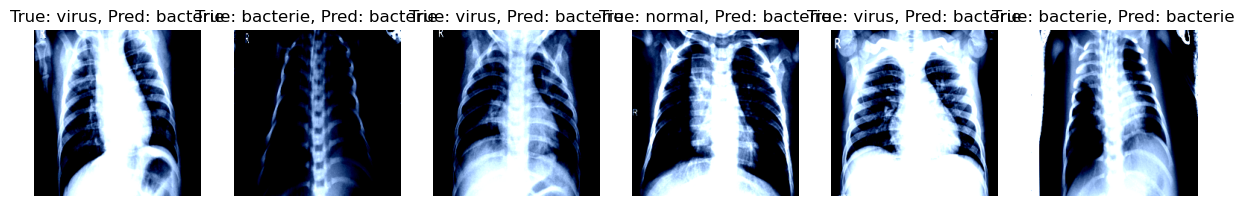

In [14]:
def visualize_predictions(dataset, model, num_images=6):
    model.eval()
    indices = np.random.choice(len(dataset), num_images, replace=False)
    fig, ax = plt.subplots(1, num_images, figsize=(15, 15))
    label_map = {0: 'normal', 1: 'bacterie', 2: 'virus'}
    
    with torch.no_grad():
        for i, idx in enumerate(indices):
            img, true_label = dataset[idx]
            img_input = img.unsqueeze(0).to(device)
            outputs = model(img_input)
            _, pred_label = torch.max(outputs, 1)
            ax[i].imshow(img.permute(1, 2, 0).cpu())
            ax[i].set_title(f"True: {label_map[true_label]}, Pred: {label_map[pred_label.item()]}")
            ax[i].axis('off')
    plt.show()

# Visualize predictions
visualize_predictions(test_dataset, model)